In [1]:
%matplotlib inline
%load_ext autoreload

import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
from copy import deepcopy
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from typing import List, Tuple
%autoreload 2

In [58]:
# Linear image scaling 
def imagesc(img,axis=(0,1)):
    im = img+0
    im -= np.amin(im,axis=axis,keepdims=True)
    mx = np.amax(im,axis=axis,keepdims=True)
    mx += (mx==0).astype(np.float32)
    im = im/mx
    return im

# Rayleigh–sommerfeld propagation
def rs_prop (u1,z,FX,FY,lmbda):
    
    k = 2*np.pi/lmbda
    H_valid = (np.sqrt(FX**2+FY**2) < 1./lmbda).astype(np.float32)
    H = H_valid * np.nan_to_num(np.exp(1j*k*z*np.sqrt(1.-(lmbda*FX)**2-(lmbda*FY)**2)))
     
    U1 = fft2(fftshift(u1))
    U2 = fftshift(H) * U1
    u2 = ifftshift(ifft2(U2))
    return u2

def visualize_psf(psf): 
    psf[:,:,0] = (psf[:,:,0] - np.min(psf[:,:,0])) / (np.max(psf[:,:,0]) - np.min(psf[:,:,0]))
    psf[:,:,1] = (psf[:,:,1] - np.min(psf[:,:,1])) / (np.max(psf[:,:,1]) - np.min(psf[:,:,1]))
    psf[:,:,2] = (psf[:,:,2] - np.min(psf[:,:,2])) / (np.max(psf[:,:,2]) - np.min(psf[:,:,2]))
    return psf

def visualize_hmap(hmap, max_val):
    hmap = np.interp(hmap, (0, max_val), (0, 255)).astype(np.uint8)
    return hmap

# visualize h1 and h2
def visualize_hmap_psfs(A, hmap, h1_from_hmap, h2_from_hmap, hmap_max_height, figsize = [10, 10]):
    plt.rcParams['figure.figsize'] = figsize
    fig, axs = plt.subplots(2,2)
    axs[0, 0].set_title('Aperture')
    axs[0, 0].imshow(A)

    axs[0, 1].set_title('height map')
    axs[0, 1].imshow(visualize_hmap(hmap, hmap_max_height))

    axs[1, 0].set_title('Aperture Only PSF')
    axs[1, 0].imshow(visualize_psf(h1_from_hmap))

    axs[1, 1].set_title('System PSF')
    axs[1, 1].imshow(visualize_psf(h2_from_hmap))

    # h1_from_hmap = cv2.resize(h1_from_hmap, (resize_res[0], resize_res[1]))
    # axs[2, 0].set_title('Downsampled PSF w/ only aperture')
    # axs[2, 0].imshow(visualize_psf(h1_from_hmap))

    # h2_from_hmap = cv2.resize(h2_from_hmap, (resize_res[0], resize_res[1]))
    # axs[2, 1].set_title('Downsampled PSF w/ hmap')
    # axs[2, 1].imshow(visualize_psf(h2_from_hmap))


In [59]:
import torch

def mycomplex(mag, phase):
    return torch.view_as_complex(torch.stack([mag * torch.cos(phase), mag * torch.sin(phase)], dim=-1))

def get_pupil_from_height_map(hmap, wavelengths, refractive_index, A):
    k = 2.*np.pi/torch.tensor(wavelengths) # wavenumber
    phi_m = k[None,None,:] * (refractive_index - 1.) * torch.tensor(hmap[:,:,None])
    phi = phi_m[None,:,:,:]
    # # pupil function
    pupil = mycomplex(torch.tensor(A[None,:,:, None]), phi)
    return pupil

def get_max_height(wavelengths, refractive_index):
    maxs = []
    for _lambda in wavelengths:
        k = 2*np.pi/_lambda
        _max = (2*np.pi) / (k * (refractive_index - 1.))
        maxs.append(_max)
    hmap_max_height = np.max(np.array(maxs))
    return hmap_max_height

def get_psf_from_aperture(X1, Y1, z1, z2, FX, FY, A, wavelengths, scaled_psf_resolution: Tuple[int, int], chw_output=False):
    
    psfs = []
    for i, _lambda in enumerate(wavelengths):
        k = 2*np.pi/_lambda

        # e-field before optical optical elements (point light source, spherical wavefront)
        u1 = np.exp(1j*k*np.sqrt(X1**2+Y1**2+z1**2)) 

        # e-field after lens & aperture plane
        u2 = u1*A

        # e-field at the sensor plane
        u3 = rs_prop(u2,z2,FX,FY,_lambda) # e-field at sensor
        _psf = np.abs(u3)**2 # System PSF
        _psf /= (np.sum(_psf) + 1.0e-7)
        psfs.append(_psf)

    psfs = np.stack(psfs, axis=-1)
    # resize psf 
    # print(f"Before resize: {psfs.shape}")
    psfs = cv2.resize(psfs, scaled_psf_resolution)
    # divide each channel by its sum to normalize the energy
    for i in range(psfs.shape[-1]):
        psfs[:,:,i] /= (np.sum(psfs[:,:,i]) + 1.0e-7)
    # covert to tensor and shape [C, 1, H, W]
    if chw_output:
        psfs = torch.tensor(psfs).permute(2, 0, 1).unsqueeze(1).float()
    return psfs

def get_psf_from_pupil(X1, Y1, z1, z2, FX, FY, A, pupil, wavelengths: List[float], scaled_psf_resolution: Tuple[int, int], chw_output=False):
    
    psfs = []
    for i, _lambda in enumerate(wavelengths):
        k = 2*np.pi/_lambda

        # e-field before optical optical elements (point light source, spherical wavefront)
        u1 = np.exp(1j*k*np.sqrt(X1**2+Y1**2+z1**2)) 

        # e-field after lens & mask  
        u2 = u1*A*pupil[..., i].reshape(u1.shape)

        # e-field at the sensor plane
        u3 = rs_prop(u2,z2,FX,FY,_lambda) # e-field at sensor
        _psf = np.abs(u3)**2 # System PSF
        _psf /= (np.sum(_psf) + 1.0e-7)
        psfs.append(_psf)

    psfs = np.stack(psfs, axis=-1)
    # resize psf 
    # print(f"Before resize: {psfs.shape}")
    psfs = cv2.resize(psfs, scaled_psf_resolution)
    # divide each channel by its sum to normalize the energy
    for i in range(psfs.shape[-1]):
        psfs[:,:,i] /= (np.sum(psfs[:,:,i]) + 1.0e-7)
    # covert to tensor and shape [C, 1, H, W]
    if chw_output:
        psfs = torch.tensor(psfs).permute(2, 0, 1).unsqueeze(1).float()
    return psfs

def get_params(Mx, My, Lx, Ly, dx, aperture_radius):
    # Image plane coords                              
    x1 = np.linspace(-Lx/2.,Lx/2.,Mx) 
    y1 = np.linspace(-Ly/2.,Ly/2.,My) 
    X1,Y1 = np.meshgrid(x1,y1)

    # Frequency coords
    fx = np.linspace(-1./(2.*dx),1./(2.*dx),Mx)
    fy = np.linspace(-1./(2.*dx),1./(2.*dx),My)
    FX,FY = np.meshgrid(fx,fy)
    
    A = (np.sqrt(X1**2+Y1**2)/(aperture_radius + 1.0e-7) <= 1.).astype(np.float32)
    return A, X1, Y1, FX, FY


In [72]:
scene_sensorsize = [8e-3, 8e-3]
pupil_resolution = [101, 101]
render_resolution = [
    pupil_resolution[0] * 2 + 1, 
    pupil_resolution[1] * 2 + 1, 
]

f_number = 2
refractive_index = 1.5
aperture_open = 1.0 
fov = [100, 100]
focal = [0., 0.]
wavelengths = [610e-9, 530e-9, 470e-9]
focal[0] = scene_sensorsize[0] / (2 * math.tan(math.radians(fov[0]) / 2))
focal[1] = scene_sensorsize[1] / (2 * math.tan(math.radians(fov[1]) / 2))
average_depth = 1.4
average_depth = np.clip(average_depth, 5 * focal[0], np.inf) # far field approximation assumption 

scene_dx = scene_sensorsize[0] / render_resolution[0] # dx in meters for the scene plane 
hmap_max_height = get_max_height(wavelengths, refractive_index)
print(f"Scene Params: dx={scene_dx}, focal={focal[0]}, hmap_max_height={hmap_max_height}")

# pupil plane 
pupil_sensorsize = focal[0] / f_number # also the diameter of the aperture
pupil_dx = pupil_sensorsize / pupil_resolution[0] # dx in meters for the pupil plane
scale = pupil_dx / scene_dx
scaled_psf_resolution = (int(scale * pupil_resolution[0]), int(scale * pupil_resolution[1]))
print(f"scaled_psf_resolution: {scaled_psf_resolution}")

aperture_radius = aperture_open * pupil_sensorsize / 2 

height_map = np.zeros((pupil_resolution[0], pupil_resolution[1])) + (hmap_max_height/2)
# random init 
height_map = np.random.uniform(0, 1, (pupil_resolution[0], pupil_resolution[1]))  
height_map *= hmap_max_height
# height_map = np.clip(height_map, 0, hmap_max_height)
print(height_map.shape)

Scene Params: dx=3.940886699507389e-05, focal=0.00335639852470912, hmap_max_height=1.22e-06
scaled_psf_resolution: (42, 42)
(101, 101)


In [73]:
A, X1, Y1, FX, FY = get_params(pupil_resolution[0], pupil_resolution[1],
                               pupil_sensorsize, pupil_sensorsize,
                               dx= pupil_dx, aperture_radius=aperture_radius)

pupil = get_pupil_from_height_map(height_map, wavelengths, refractive_index, A)

psf_aperture = get_psf_from_aperture(X1=X1, Y1=Y1, z1=average_depth, 
                                     z2=focal[0], FX=FX, FY=FY, 
                                     A=A, wavelengths=wavelengths, scaled_psf_resolution=scaled_psf_resolution)

psf_system = get_psf_from_pupil(X1=X1, Y1=Y1, z1=average_depth, 
                                z2=focal[0], FX=FX, FY=FY, A=A, 
                                pupil=pupil.cpu().numpy(), wavelengths=wavelengths ,scaled_psf_resolution=scaled_psf_resolution)
print(f"psf_aperture={psf_aperture.shape}, psf_aperture={psf_system.shape}")

psf_aperture=(42, 42, 3), psf_aperture=(42, 42, 3)


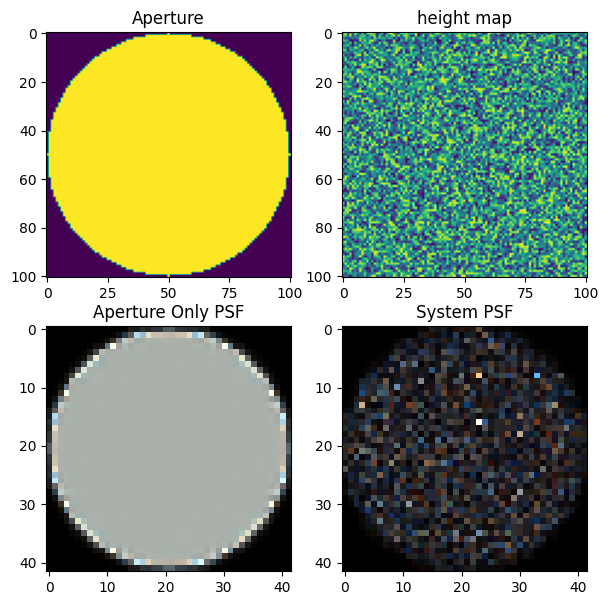

In [74]:
visualize_hmap_psfs(A, height_map, psf_aperture, psf_system, 
                    hmap_max_height=hmap_max_height, 
                    figsize = [7, 7]
                    )
                    # resize_res=scaled_psf_resolution, 